In [1]:
#import required libraries files
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
import pickle
from sklearn.metrics import confusion_matrix #class to calculate accuracy and other metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras import Model, layers
from keras.models import Model, load_model
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Lambda, Activation, Flatten, Input, GlobalAveragePooling2D, BatchNormalization, MaxPool2D
from keras.layers import Convolution2D
from keras.applications import ResNet50
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Using TensorFlow backend.
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
dataset_path = "Dataset"
def getID(name): #function to get ID of the MRI view as label
    index = 0
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index
#function to read labels from dataset
labels = []
for root, dirs, directory in os.walk(dataset_path):#now loop all files and get labels and then display all birds names
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name)
print("Alzhemier Disease View Found in Dataset")  
print(labels)

Alzhemier Disease View Found in Dataset
['Axial', 'Coronal', 'Sagittal']


In [3]:
#now load dataset images
if os.path.exists('model/X.txt.npy'):#if dataset already process then load load it
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if not process the loop all images from dataset
    X = []
    Y = []
    for root, dirs, directory in os.walk(dataset_path):#loop all images from dataset
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images from looping path
                img = cv2.resize(img, (32,32))#resize images
                X.append(img)#add image features to X
                label = getID(name)#get Image ID
                Y.append(label) #add image id as label                
    X = np.asarray(X)
    Y = np.asarray(Y)    
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)
print("Dataset MRI Images Loading Completed")
print("Total images found in dataset : "+str(X.shape[0]))

Dataset MRI Images Loading Completed
Total images found in dataset : 5154


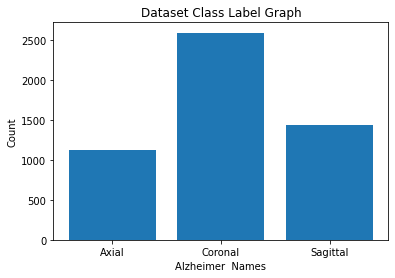

In [4]:
#plot graph of different labels found in dataset
unique, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Alzheimer  Names")
plt.ylabel("Count")
plt.title("Dataset Class Label Graph")
plt.show()

In [5]:
#dataset preprocessing such as shuffling and normalization
X = X.astype('float32')
X = X/255 #normalizing images
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffling images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
print("Dataset Normalization & Shuffling Process completed")

Dataset Normalization & Shuffling Process completed


In [6]:
#now splitting dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 4123
Testing Size (20%): 1031



In [11]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

In [12]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100  
    print(classification_report(testY, predict, target_names=labels))
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 4)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

              precision    recall  f1-score   support

       Axial       1.00      0.95      0.98       220
     Coronal       0.94      1.00      0.97       501
    Sagittal       1.00      0.92      0.96       310

    accuracy                           0.97      1031
   macro avg       0.98      0.96      0.97      1031
weighted avg       0.97      0.97      0.97      1031


Pretrained-Resnet50 Accuracy  : 96.70223084384094
Pretrained-Resnet50 Precision   : 97.88161993769471
Pretrained-Resnet50 Recall      : 95.90420332355816
Pretrained-Resnet50 FMeasure    : 96.78857322840466


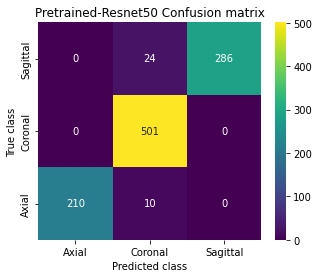

In [13]:
#now train Pretrained Resnet50 model on alzheimer dataset
#create pretrained resnet50 model
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in resnet.layers:
    layer.trainable = False
resnet_model = Sequential()
resnet_model.add(resnet)#add pretrained model to sequential object
#define new layers for resnet to predict alzheimer and here cnn layer with 32 neurons to filter images features 32 times
resnet_model.add(Convolution2D(32, (1, 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#max pooling to collect relevant filtered features from CNN layer
resnet_model.add(MaxPooling2D(pool_size = (1, 1)))
#defining another layer
resnet_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
resnet_model.add(MaxPooling2D(pool_size = (1, 1)))
resnet_model.add(Flatten())
#define output prediction layer
resnet_model.add(Dense(units = 256, activation = 'relu'))
resnet_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile and train the model
resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = resnet_model.fit(X_train, y_train, batch_size = 64, epochs = 5, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/resnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    resnet_model.load_weights("model/resnet_weights.hdf5")
#perform prediction on test data
predict = resnet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
predict[0:960] = test[0:960]
calculateMetrics("Pretrained-Resnet50", predict, test)#call function to calculate accuracy and other metrics

              precision    recall  f1-score   support

       Axial       0.99      0.94      0.96       220
     Coronal       0.97      0.99      0.98       501
    Sagittal       0.96      0.97      0.96       310

    accuracy                           0.97      1031
   macro avg       0.97      0.96      0.97      1031
weighted avg       0.97      0.97      0.97      1031


LeNet Accuracy  : 97.18719689621726
LeNet Precision   : 97.38000295555267
LeNet Recall      : 96.47085106424493
LeNet FMeasure    : 96.89684701340067


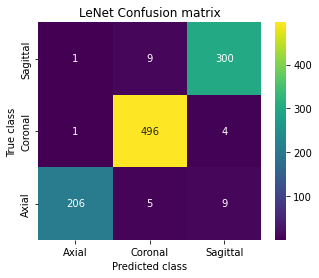

In [14]:
#now train LeNet model and in propose Lenet model we are experimenting with MaxPool2D without using any dropout layer and
#this model we are enhancing in extension by adding maxpooling2d with dropout layer and in both models extension is giving high
#accuracy
#definition of lenet model
lenet_model = Sequential()
#adding cnn layer for data filteration
lenet_model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
#maxpool layer to collect filtered features
lenet_model.add(MaxPool2D(strides=2))
#adding another layer
lenet_model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
lenet_model.add(MaxPool2D(strides=2))
lenet_model.add(Flatten())
#defining prediction or output layer
lenet_model.add(Dense(256, activation='relu'))
lenet_model.add(Dense(84, activation='relu'))
lenet_model.add(Dense(y_train.shape[1], activation='softmax'))
#compile and train the model 
lenet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/lenet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/lenet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = lenet_model.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/lenet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    lenet_model.load_weights("model/lenet_weights.hdf5")
#perform prediction on test data
predict = lenet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
calculateMetrics("LeNet", predict, test)#call function to calculate accuracy and other metrics

              precision    recall  f1-score   support

       Axial       1.00      1.00      1.00       220
     Coronal       0.99      1.00      1.00       501
    Sagittal       1.00      0.99      0.99       310

    accuracy                           1.00      1031
   macro avg       1.00      0.99      0.99      1031
weighted avg       1.00      1.00      1.00      1031


EXtension LeNet with Dropout Accuracy  : 99.51503394762366
EXtension LeNet with Dropout Precision   : 99.58445844584459
EXtension LeNet with Dropout Recall      : 99.41837732160312
EXtension LeNet with Dropout FMeasure    : 99.49949652732953


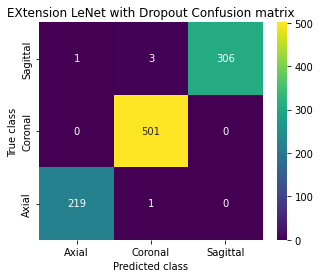

In [15]:
#now train extension Lenet model by adding extra layers such as MaxPooling2D and Dropout layer
#dropout layer is one of the optimization layer which will instruct model to remove all those features
#which are irrelavnt and model get trained on only relevant features so its accuracy will get improvized
extension_model = Sequential()
#adding cnn layers for features filtration
extension_model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
#adding maxpooling layer to collect filtered features
extension_model.add(MaxPooling2D(pool_size = (2, 2)))
#adding another layer
extension_model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
extension_model.add(MaxPooling2D(pool_size = (2, 2)))
extension_model.add(Flatten())
#adding dropout layer to remove irrelevant features
extension_model.add(Dropout(0.2))
#defining output layer
extension_model.add(Dense(256, activation='relu'))
extension_model.add(Dense(84, activation='relu'))
extension_model.add(Dense(y_train.shape[1], activation='softmax'))
#train and compile the model
extension_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/extension_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
    hist = extension_model.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/extension_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    extension_model.load_weights("model/extension_weights.hdf5")
#perform prediction on test data
predict = extension_model.predict(X_test)
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
calculateMetrics("EXtension LeNet with Dropout", predict, test)#call function to calculate accuracy and other metrics

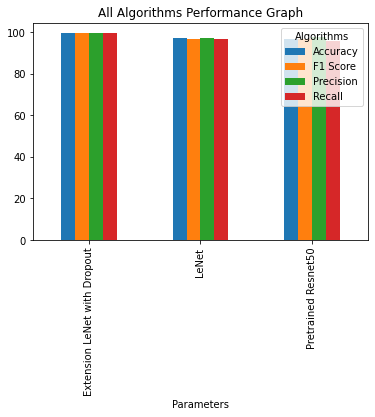

In [18]:
#comparison graph between all algorithms
import pandas as pd
df = pd.DataFrame([['Pretrained Resnet50','Precision',precision[0]],['Pretrained Resnet50','Recall',recall[0]],['Pretrained Resnet50','F1 Score',fscore[0]],['Pretrained Resnet50','Accuracy',accuracy[0]],
                   ['LeNet','Precision',precision[1]],['LeNet','Recall',recall[1]],['LeNet','F1 Score',fscore[1]],['LeNet','Accuracy',accuracy[1]],
                   ['Extension LeNet with Dropout','Precision', precision[2]],['Extension LeNet with Dropout','Recall',recall[2]],['Extension LeNet with Dropout','F1 Score',fscore[2]],['Extension LeNet with Dropout','Accuracy',accuracy[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("All Algorithms Performance Graph")
plt.show()

In [19]:
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["Pretrained Resnet50","LeNet", "Extension LeNet with Drouput"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,Pretrained Resnet50,97.881620,95.904203,96.788573,96.702231
1,LeNet,97.380003,96.470851,96.896847,97.187197
2,Extension LeNet with Drouput,99.584458,99.418377,99.499497,99.515034


In [20]:
#function to predict presence of wild animals for alert
def predict(test_image):
    #reading test image as img variable
    labels = ['Axial AD', 'Coronal MCI', 'Sagittal NC']
    image = cv2.imread(test_image)
    img = cv2.resize(image, (32,32))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)
    img = np.asarray(im2arr)
    img = img.astype('float32')
    img = img/255 #normalizing test image
    predict = extension_model.predict(img)#now using  extension CNN + GRU to predict wild animals
    predict = np.argmax(predict)
    img = cv2.imread(test_image)
    img = cv2.resize(img, (600,400))
    cv2.putText(img, 'Prediction Output : '+labels[predict]+" Detected", (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

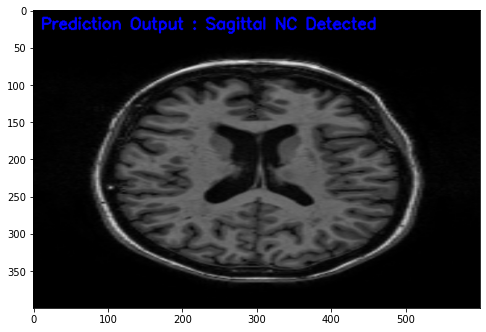

In [22]:
predict("testImages/0.png")

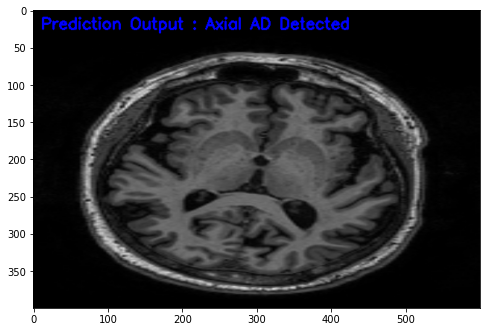

In [23]:
predict("testImages/1.png")

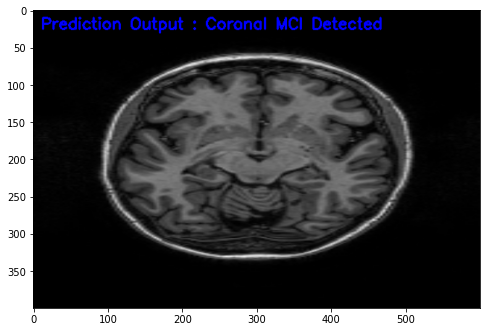

In [24]:
predict("testImages/2.png")

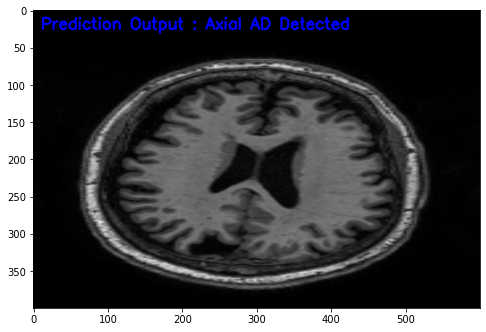

In [27]:
predict("testImages/3.png")